# apply instruments settings

In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config_custom as hdc

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# connect to devices
pg  = PulseGenerator(ip=hdc.PS_IP, chmap=hdc.PS_chmap) 
mwsyn = Synthesizer(hdc.VDISYN_SN, 
                    vidpid=hdc.VDISYN_VIDPID,
                    baudrate=hdc.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hdc.LASER_SN)
laser.open()
# mwsyn.close()
# laser.close()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0
VDI Sythesizer Serail Port Open


# Set parameters

In [438]:
current_percent = 99.09
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [30]:
# laserpower = 145.0
# laser.laser_off()
# laser.set_analog_control_mode("power")
# laser.set_modulation_state("CW")
# laser.set_laser_power(laserpower, save_memory=False)
# laser.laser_on()

In [202]:
f_NVguess = 398.5607725381851
freq = f_NVguess/24.0
# freq = 380/24.0
errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.606698855757713 GHz
Actual Output CW Freqeuncy :16.606698855757713 GHz


In [534]:
tenmhz = 10.00/1E3 # GHz
laser_init = 1000.0
wait_init = 600.0
mw_dur_start = 10.0
mw_dur_stop = 1500.0
mw_dur_step = 5.0
mw_dur = np.arange(mw_dur_start, mw_dur_stop+mw_dur_step, mw_dur_step)
wait_read = 100.0
laser_read = 800.0

# here is to fix the timing
totaltime_max = laser_init+wait_init+mw_dur_stop+wait_read+laser_read
tenmhzmultiple = int(tenmhz*totaltime_max)
sampling_rate = tenmhz/tenmhzmultiple
padding_fix = totaltime_max-1/sampling_rate
padding = padding_fix+mw_dur_stop-mw_dur # depends on MW duration
num_pt = len(mw_dur)

In [535]:
clockmultiple = 1
clock_rate = clockmultiple*sampling_rate #GHz
daq_offset = 1.0/clock_rate*1.0
delaydiff = 200.0
readoffset = 350.0
daqpadding = laser_read - delaydiff - readoffset
# daqpadding = 1.0/clock_rate*1.0
# daqpadding = int(clock_rate*(1.0/sampling_rate-(laser_read-250.0)))/clock_rate
# daqpadding = 0.0
daqtrigdelay = 1.0/clock_rate*0.0
seq_daqtrig = [(daq_offset - daqpadding, LOW)] + [(100.0/clock_rate, HIGH), (1.0/clock_rate*(num_pt*2*clockmultiple-100)-daqpadding-daq_offset, LOW)] + [(daqtrigdelay,LOW)]
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple+int(daqpadding*clock_rate))
# seq_clock = [(daqpadding, LOW)] + [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple)
seq_clock = [(0.5/clock_rate-daqpadding, HIGH), (0.5/clock_rate, LOW)] + [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*(num_pt*2*clockmultiple+int(daqtrigdelay*clock_rate)-1) + [(daqpadding, HIGH)]
# seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]

seq_laser = []
seq_mwA = []
skip = 0
# for mwd, pd in zip(mw_dur, padding):
for ii in range(len(mw_dur)-skip):
    mwd = mw_dur[ii]
    pd = padding[ii]
    seq_laser_sub = [(padding_fix+pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH)]
    seq_laser_sub_alloff = [(padding_fix+pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW)]
    seq_mwA_sub = [(padding_fix+pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW)]
    seq_mwA_noMW_sub = [(padding_fix+pd, LOW), (laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW)]
    # seq_laser_sub = [(laser_init, HIGH), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, HIGH), (pd, LOW)]
    # seq_mwA_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, HIGH), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]
    # seq_mwA_noMW_sub = [(laser_init, LOW), (wait_init, LOW), (mwd, LOW), (wait_read, LOW), (laser_read, LOW), (pd, LOW)]

    seq_laser += seq_laser_sub*2
    seq_mwA += seq_mwA_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_noMW_sub + seq_mwA_noMW_sub
    # seq_mwA += seq_mwA_sub + seq_mwA_sub
seq_laser += (seq_laser_sub_alloff + seq_laser_sub_alloff)*skip
seq_mwA += (seq_mwA_noMW_sub + seq_mwA_noMW_sub)*skip

seq_laser = [(daqtrigdelay,LOW)] + seq_laser
# seq_laser = [(0.5/clock_rate, HIGH),(0.5/clock_rate, HIGH)]*(num_pt*2*clockmultiple+int(daqtrigdelay*clock_rate))
seq_mwA = [(daqtrigdelay,LOW)] + seq_mwA
# seq_laser += [(daqpadding, LOW)]
# seq_mwA += [(daqpadding, LOW)]


rrr = 8
pg.setDigital("laser", seq_laser*rrr)
pg.setDigital("mw_A", seq_mwA*rrr)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
pg.setDigital("daqtrig", seq_daqtrig*rrr)
pg.setDigital("clock", seq_clock*rrr)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)

In [537]:
# signal reading parameters
min_volt = -0.005 # [V]
max_volt = 0.03
samplerate_read = sampling_rate*1E9 # 500kHz .max ext clock rate of NI6343, check it by yourself!
basetime = 1.0/samplerate_read
num_readsample = num_pt*2
timeout_read = max(num_readsample/samplerate_read, 10)
buffer_readpoint = np.zeros(num_readsample, dtype=np.float64, order='C')

readtask = nidaqmx.Task("readsignal")
# readtask.close()
readtask.ai_channels.add_ai_voltage_chan(
            hdc.NI_ch_APD,"",
            # TerminalConfiguration.RSE,
            TerminalConfiguration.DIFF,
            min_volt,max_volt,
            VoltageUnits.VOLTS
        )
# readtask.timing.cfg_samp_clk_timing(samplerate_read, source="", active_edge=Edge.RISING, sample_mode=AcquisitionType.FINITE, samps_per_chan=num_readsample)
readtask.timing.cfg_samp_clk_timing(
    samplerate_read, 
    source=hdc.NI_ch_Clock, 
    active_edge=Edge.RISING, 
    sample_mode=AcquisitionType.FINITE, 
    samps_per_chan=num_readsample)
read_trig = readtask.triggers.start_trigger
read_trig.cfg_dig_edge_start_trig(hdc.NI_ch_Trig, Edge.RISING)

reader = AnalogSingleChannelReader(readtask.in_stream)
reader.read_all_avail_samp  = True

In [536]:
readtask.close()

# Start measurement


In [449]:
laser.laser_on() # turn off laser

In [539]:
pg.stream(n_runs=INF)
pg.startNow()
# signal = np.zeros(num_pt)
# background = np.zeros(num_pt)
# repeat measurement
num_repeat = 50000
signal_av = np.zeros(num_pt, dtype=np.float64, order='C')
background_av = np.zeros(num_pt, dtype=np.float64, order='C')

for kkk in range(num_repeat):
    readtask.start() # ready to read data
    num_read = reader.read_many_sample(
            buffer_readpoint,
            num_readsample,
            timeout_read
        )
    readtask.wait_until_done(timeout=timeout_read) # block the code below, optional
    readtask.stop()
    # laser.laser_off()
    # readtask.close()
    signal_av += np.copy(buffer_readpoint[0::2])
    background_av += np.copy(buffer_readpoint[1::2])
signal_av = signal_av/num_repeat
background_av = background_av/num_repeat
contrast = (signal_av-background_av)/background_av

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
# ax1.plot(mw_dur, signal_av*1E3, linewidth=0.5, label="signal", color="orange")
# ax1.plot(mw_dur, background_av*1E3, linewidth=0.5, label="ref", color="green")
# ax2.plot(mw_dur, contrast*100.0, linewidth=2, label="contrast", color='royalblue')
idxstart = 0
idxend = len(mw_dur)
ax1.plot(mw_dur[idxstart:idxend], signal_av[idxstart:idxend]*1E3, linewidth=0.5, label="signal", color="orange")
ax1.plot(mw_dur[idxstart:idxend], background_av[idxstart:idxend]*1E3, linewidth=0.5, label="ref", color="green")
ax2.plot(mw_dur[idxstart:], contrast[idxstart:]*100.0, linewidth=2, label="contrast", color='royalblue')

ax1.set_xlabel("MW time [ns]")
ax1.set_ylabel("PL [mV]")
ax2.set_ylabel("Contrast [%]", color='royalblue')
ax1.legend(loc='best')
plt.title("Rabi (ms=0 to +1)")
plt.show()

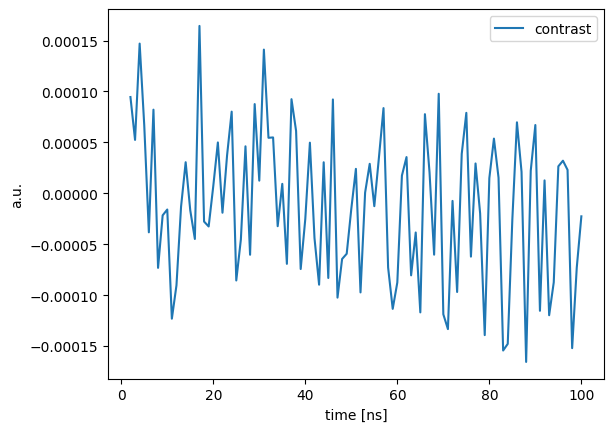

In [88]:
import matplotlib.pyplot as plt

# plt.plot(mw_dur, signal_av, label="signal")
# plt.plot(mw_dur, background_av, label="ref")
plt.plot(mw_dur, contrast, label="contrast")
plt.xlabel("time [ns]")
plt.ylabel("a.u.")
plt.legend()
plt.show()

In [87]:
np.savetxt('output\\rabi_initwait10us_(timens_signal_background)_20240430.txt', np.c_[mw_dur, signal_av, background_av])

In [ ]:
pg.constant(OutputState.ZERO())
laser.laser_off() # turn off laser
readtask.close()
# mwsyn.reboot()

c:\ProgramData\miniconda3\envs\hfnvenv\lib\site-packages\nidaqmx\task.py:355: ResourceWarning: Attempted to close NI-DAQmx task of name "readsignal" but task was already closed.
  warnings.warn(


In [406]:
mwsyn.reboot()

MW Synthesizer Rebooted!


In [48]:
# close the communication
laser.close()
mwsyn.close()
pg.reset()